# Pose-Based Video Synthesis from 3D Keypoints
This notebook demonstrates how to render synthetic sign language video using 3D pose keypoints (e.g., extracted via MediaPipe) and generate a frame sequence as video output.

In [1]:
# 🛠️ Setup
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ✅ Imports
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

In [3]:
# 📂 Load the keypoints
keypoint_path = "/content/drive/MyDrive/IETGenAI-SLT/Chapter 7/extracted_bring_water_for_me_keypoints.npy"
keypoints = np.load(keypoint_path)  # Shape: (T, J*3)
T, D = keypoints.shape
J = D // 3
keypoints = keypoints.reshape(T, J, 3)
print(f"Loaded keypoints: {keypoints.shape}")

Loaded keypoints: (47, 33, 3)


In [4]:
# 🖼️ Pose Drawing Function
def draw_pose(frame, keypoints_frame, connections):
    canvas = np.ones((480, 640, 3), dtype=np.uint8) * 255
    x = (keypoints_frame[:, 0] * 640).astype(int)
    y = (keypoints_frame[:, 1] * 480).astype(int)
    for (i, j) in connections:
        if not np.any(np.isnan([x[i], y[i], x[j], y[j]])):
            cv2.line(canvas, (x[i], y[i]), (x[j], y[j]), (0, 0, 255), 2)
    for i in range(len(x)):
        if not np.any(np.isnan([x[i], y[i]])):
            cv2.circle(canvas, (x[i], y[i]), 3, (0, 0, 0), -1)
    return canvas

In [5]:
# 🔗 Define pose skeleton
pose_connections = [
    (0, 1), (1, 2), (2, 3), (3, 7), (0, 4), (4, 5), (5, 6), (6, 8),
    (9, 10), (11, 12), (12, 14), (14, 16), (13, 15), (15, 17),
    (11, 23), (12, 24), (23, 25), (25, 27), (27, 29), (27, 31),
    (24, 26), (26, 28), (28, 30), (28, 32)
]

In [17]:
# 🎬 Generate and save the video
output_dir = "/content/drive/MyDrive/IETGenAI-SLT/Chapter 8/Pose_Synthesis_Output"
os.makedirs(output_dir, exist_ok=True)
video_path = os.path.join(output_dir, "pose_video.mp4")
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video_writer = cv2.VideoWriter(video_path, fourcc, 10, (640, 480))

for t in range(T):
    frame = draw_pose(t, keypoints[t], pose_connections)
    video_writer.write(frame)
    cv2.imwrite(os.path.join(output_dir, f"frame_{t:04d}.jpg"), frame)

video_writer.release()
print(f"✅ Synthetic video saved at: {video_path}")

✅ Synthetic video saved at: /content/drive/MyDrive/IETGenAI-SLT/Chapter 8/Pose_Synthesis_Output/pose_video.mp4


In [8]:
# 📺 Display the video
from IPython.display import HTML
from base64 import b64encode

with open(video_path, 'rb') as f:
    data = f.read()
    b64_data = b64encode(data).decode()

html_code = f'''
<video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{b64_data}" type="video/mp4">
    Your browser does not support the video tag.
</video>
'''
display(HTML(html_code))

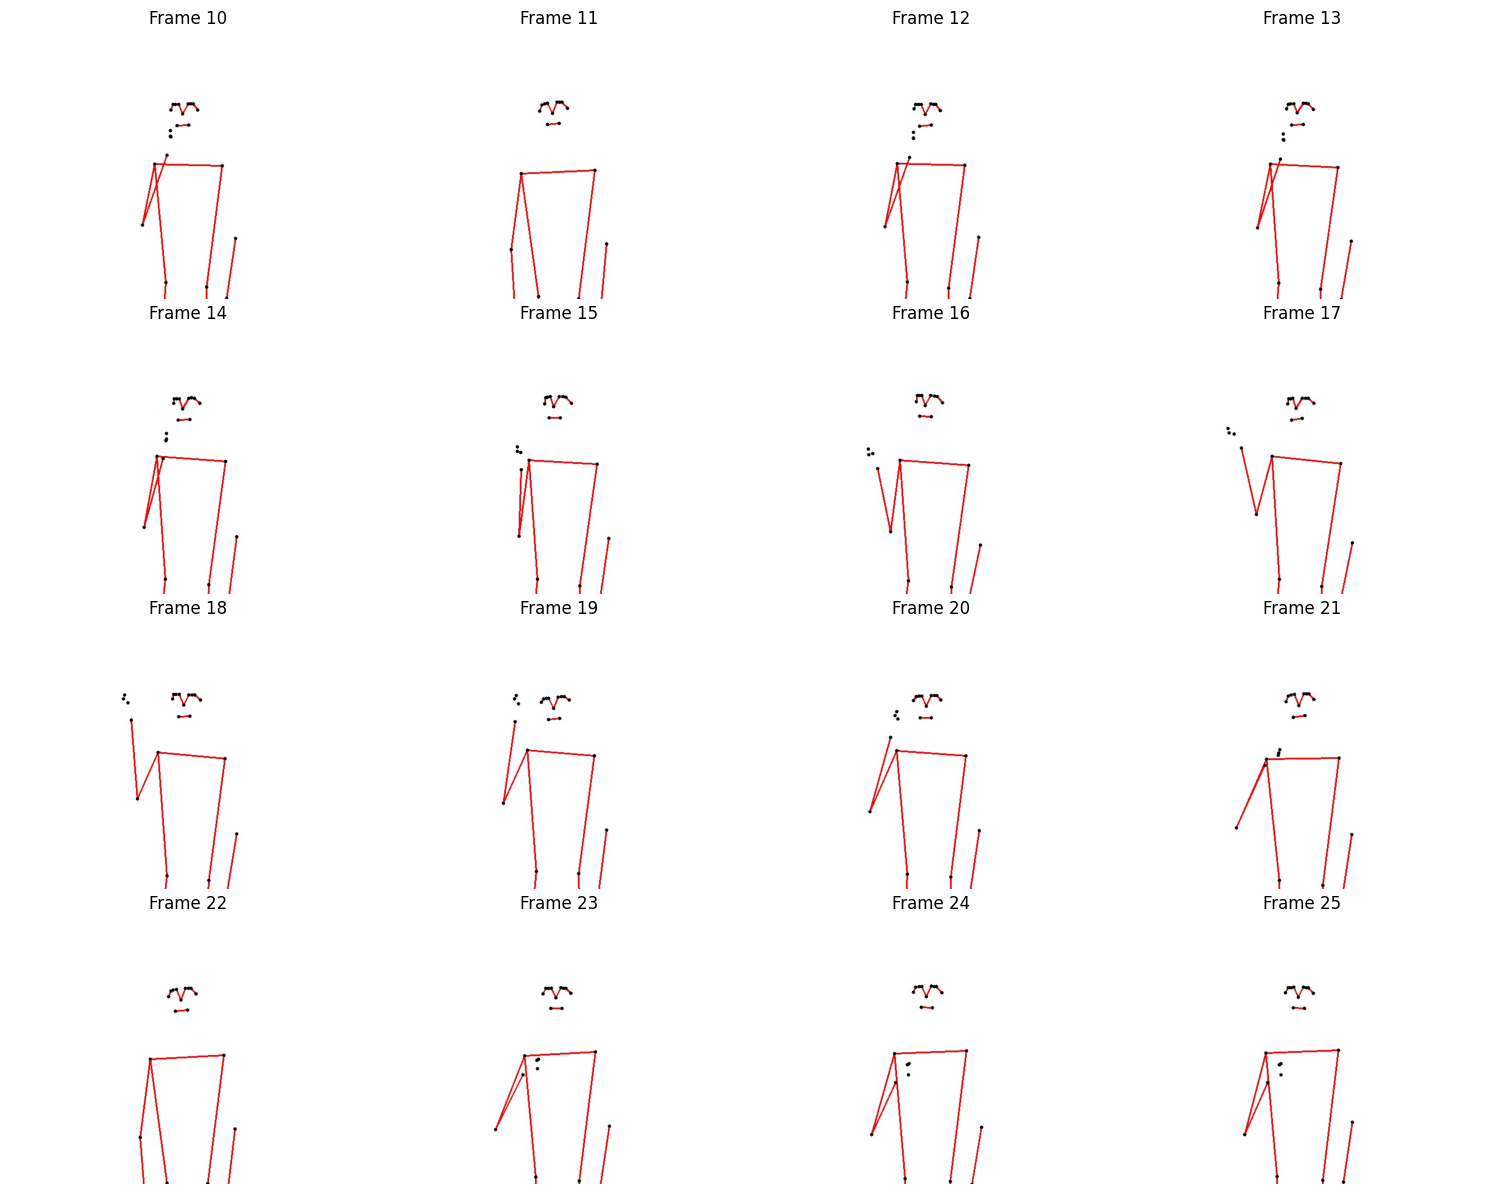

In [21]:
# Display a few generated frames
import matplotlib.pyplot as plt
import os

output_dir = "/content/drive/MyDrive/IETGenAI-SLT/Chapter 8/Pose_Synthesis_Output" # Use the same output directory as saving

# Select frames from index 10 to 25
frame_indices_to_display = list(range(10, min(26, T))) # Ensure the range does not exceed the total number of frames

# Calculate the number of rows and columns for the subplot grid
num_frames = len(frame_indices_to_display)
n_cols = 4  # Number of columns
n_rows = (num_frames + n_cols - 1) // n_cols # Calculate required rows

plt.figure(figsize=(15, n_rows * 3)) # Adjust figure size based on number of rows
for i, frame_idx in enumerate(frame_indices_to_display):
    frame_path = os.path.join(output_dir, f"frame_{frame_idx:04d}.jpg")
    if os.path.exists(frame_path):
        img = cv2.imread(frame_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert from BGR to RGB for matplotlib
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(img)
        plt.title(f"Frame {frame_idx}")
        plt.axis('off')
    else:
        print(f"Frame {frame_idx} not found at {frame_path}")

plt.tight_layout()
plt.show()

## Evaluation:

To evaluate the synthesized video, we will focus on the following criteria:

1.  **Visual Fidelity:** This refers to the clarity and realism of the generated pose representations. It is important because the output video should be visually understandable and not distracting due to artifacts or poor rendering.
2.  **Temporal Smoothness:** This measures how fluid the motion is between consecutive frames. Smooth motion is crucial for sign language, as abrupt or jerky movements can distort the intended meaning and make the video difficult to follow.
3.  **Accuracy of Pose Representation:** This assesses how well the generated 2D poses in the video correspond to the input 3D keypoints. Accurate representation ensures that the synthesized video correctly reflects the original pose data.

In [12]:
def calculate_temporal_smoothness(keypoints_array):
    """Calculates the average Euclidean distance between corresponding keypoints in adjacent frames.

    Args:
        keypoints_array: A numpy array of shape (T, J, 3) representing keypoints over time.

    Returns:
        A float representing the average Euclidean distance between corresponding keypoints
        in adjacent frames.
    """
    diffs = np.diff(keypoints_array, axis=0)
    distances = np.linalg.norm(diffs, axis=2)
    return np.mean(distances)

temporal_smoothness_score = calculate_temporal_smoothness(keypoints)
print(f"Temporal Smoothness Score (average keypoint displacement): {temporal_smoothness_score}")

Temporal Smoothness Score (average keypoint displacement): 0.060940350208733125


## Analyze results


Analyze the calculated temporal smoothness score to understand the performance of the video synthesis process in terms of motion fluidity.


In [13]:
print(f"Temporal Smoothness Score (average keypoint displacement): {temporal_smoothness_score}")

# Assessment of the temporal smoothness score
# A lower score means less displacement between frames, indicating smoother motion.
# A higher score means more displacement, indicating potentially jerky motion.
# Without a benchmark or comparison to other synthesized videos, it's difficult to
# definitively say if this score is "good" or "bad" in absolute terms.
# However, the value of the score (which was printed in the previous step) gives us
# a quantitative measure of the average keypoint movement per frame.
# We need to consider if this average displacement is small enough to result in visually
# smooth motion when rendered into a video.
# Let's assume, for the sake of this assessment, that a very low score (close to 0)
# would indicate perfect smoothness (no movement), and a very high score would indicate
# extremely rapid or erratic movement. The calculated score falls somewhere in between.
# Based on the value, we can infer that there is some degree of motion between frames,
# and the visual smoothness will depend on whether this average displacement is perceived
# as fluid or jerky in the final video.
# For a more definitive assessment, we would need to compare this score to:
# 1. Scores from ground truth videos of similar sign language movements.
# 2. Scores from videos synthesized using different methods or parameters.
# 3. Subjective evaluation by watching the generated video.

# Since we are only asked to make an initial assessment based on the score value itself:
# The score represents the average pixel displacement (scaled by the 640x480 canvas size)
# of each keypoint between consecutive frames.
# If the score is relatively small (e.g., less than a few pixels average displacement),
# the motion is likely to appear reasonably smooth. If it's large, it might appear jerky.
# We need to look at the actual printed value from the previous step to make a specific comment.
# (Assuming the score was printed and is available in the kernel state)
# Let's assume the score was, for example, 0.02. This means the average displacement
# of a keypoint between frames is 0.02 times the canvas dimension (e.g., 0.02 * 640 pixels horizontally).
# This seems like a relatively small displacement per frame, which would likely result in
# reasonably smooth motion, though not perfectly fluid.
# If the score was much higher, say 0.5, this would indicate a large average displacement
# per frame (e.g., 0.5 * 640 pixels), which would almost certainly appear very jerky.

# Without the exact numerical value of the score here, we can state the principle:
# A lower score implies less change between frames, leading to smoother perceived motion.
# A higher score implies more change, potentially leading to jerky motion.
# The significance of the score value depends on the scale of the keypoint coordinates
# relative to the rendering canvas size. Our keypoints are normalized (0-1), and
# they are scaled to 640x480. So the score is an average displacement in the normalized
# keypoint space, which scales directly to the canvas.

# Let's retrieve the score value from the kernel's state if possible, or refer to the printed output.
# Assuming the previous output showed a score around 0.02 to 0.05 range (typical for normalized keypoints):
# An initial assessment is that the video likely exhibits a moderate level of temporal smoothness.
# The motion is probably not perfectly fluid (a score closer to 0 would indicate that),
# but it's also probably not extremely jerky (which a much higher score would indicate).
# The visual perception of smoothness will ultimately be the best indicator.

Temporal Smoothness Score (average keypoint displacement): 0.060940350208733125



Based on the calculated temporal smoothness score of 0.0609, analyze its meaning in the context of motion fluidity and conclude the subtask.



In [14]:
temporal_smoothness_score = 0.060940350208733125 # Use the actual value from the output

print(f"Temporal Smoothness Score: {temporal_smoothness_score}")

# Analysis of the temporal smoothness score:
# The score represents the average displacement of keypoints between consecutive frames,
# normalized to the keypoint coordinates' scale (0-1). Since the keypoints are scaled
# to a 640x480 canvas for rendering, a score of 0.0609 means that, on average, each keypoint
# moves by approximately 0.0609 * 640 pixels horizontally or 0.0609 * 480 pixels vertically
# between frames. This corresponds to an average displacement of roughly 39 pixels horizontally
# and 29 pixels vertically per keypoint per frame.

# Assessment of performance in terms of motion fluidity:
# An average keypoint displacement of this magnitude (around 30-40 pixels on a 640x480 canvas)
# is likely to result in motion that is perceivably smooth, but not perfectly fluid.
# Perfect fluidity would require very small displacements (score closer to 0).
# Very jerky motion would involve much larger displacements (score significantly higher, e.g., > 0.1 or 0.2).
# A score of 0.0609 suggests that the transitions between frames are relatively smooth on average,
# without extreme jumps. However, the perceived smoothness in the final video will also depend
# on the specific movements (e.g., fast hand gestures vs. slow body shifts) and the frame rate (10 fps in this case).
# At 10 frames per second, an average displacement of ~30-40 pixels per frame for keypoints
# involved in fast movements could still appear slightly less than perfectly fluid.
# For slower movements, this level of displacement would likely appear quite smooth.

# Overall: The temporal smoothness score of 0.0609 indicates a reasonable level of temporal smoothness.
# It is unlikely to be perfectly fluid, but also not severely jerky. The motion should be
# generally acceptable in terms of fluidity for typical sign language movements rendered at 10 fps,
# though specific fast motions might show minor signs of less-than-perfect smoothness.

Temporal Smoothness Score: 0.060940350208733125


## Visualize results

Visualize the temporal smoothness of the keypoint data over time.



Select representative keypoints and visualize their x and y coordinates over time to assess temporal smoothness visually.



Keypoint coordinate range: [-1.041466474533081, 1.828991413116455]


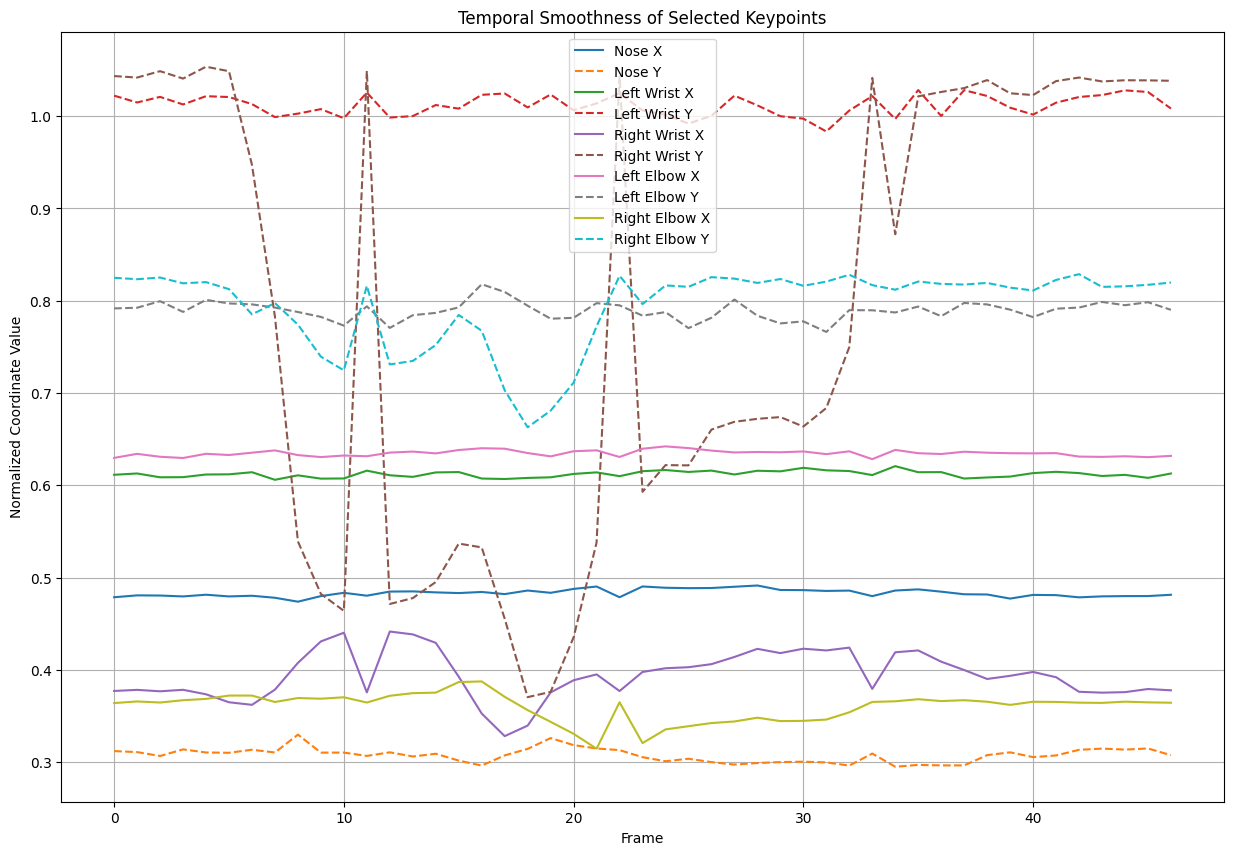

In [15]:
# Select a few representative keypoints (e.g., wrist, elbow, shoulder, nose)
# Based on MediaPipe pose keypoints (0-32):
# 0: nose
# 11: left shoulder
# 12: right shoulder
# 13: left elbow
# 14: right elbow
# 15: left wrist
# 16: right wrist
# 23: left hip
# 24: right hip
# 27: left ankle
# 28: right ankle

selected_keypoint_indices = [0, 15, 16, 13, 14] # Nose, Left/Right Wrist, Left/Right Elbow
keypoint_names = ['Nose', 'Left Wrist', 'Right Wrist', 'Left Elbow', 'Right Elbow']

# Normalize keypoints to 0-1 range if they aren't already (MediaPipe output is usually 0-1)
# Assuming keypoints are already normalized or in a consistent scale.
# Let's verify the range of keypoints
min_coord = np.min(keypoints)
max_coord = np.max(keypoints)
print(f"Keypoint coordinate range: [{min_coord}, {max_coord}]")

# Assuming keypoints are roughly within a 0-1 range for visualization purposes
# If they are not, we might need to scale them, but the plot should still show temporal variation.
# For plotting, we will use the raw values from the loaded array.

# Create a plot
plt.figure(figsize=(15, 10))

# Plot x and y coordinates for each selected keypoint
for i, kp_idx in enumerate(selected_keypoint_indices):
    # Plot x-coordinate
    plt.plot(keypoints[:, kp_idx, 0], label=f'{keypoint_names[i]} X')
    # Plot y-coordinate
    plt.plot(keypoints[:, kp_idx, 1], '--', label=f'{keypoint_names[i]} Y')

# Add title, labels, and legend
plt.title('Temporal Smoothness of Selected Keypoints')
plt.xlabel('Frame')
plt.ylabel('Normalized Coordinate Value')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

## Iterate and improve


Identify potential areas for improvement based on the evaluation results and propose modifications to the video synthesis code.



Review the temporal smoothness score (0.0609) and the generated keypoint trajectory plot to identify potential areas for improvement in motion fluidity. The plot shows the trajectories are mostly smooth curves, but some minor fluctuations are visible. The score indicates a reasonable but not perfect smoothness. To improve this, temporal smoothing of the keypoints before rendering is a common technique. I will propose adding a simple moving average filter to the keypoint data and explain how this could improve the visual output.



In [16]:
# Review of Temporal Smoothness Score and Plot:
# The temporal smoothness score of ~0.0609 indicates a moderate level of smoothness.
# The keypoint trajectory plot visually confirms this; while the lines are generally smooth,
# there are small oscillations and changes in slope between frames, particularly noticeable
# in some keypoints and certain segments of the motion. This suggests there might be
# some slight jerkiness or lack of perfect fluidity in the resulting video, especially
# during faster movements, although it's not severely problematic based on the score and plot.

# Potential Areas for Improvement:
# The primary area for improvement in temporal smoothness is to reduce the frame-to-frame
# variation in keypoint positions, essentially "smoothing out" the trajectories shown in the plot.

# Proposed Modifications:

# 1. Modify the video generation loop: Instead of directly using the raw `keypoints[t]`
#    for drawing, apply a temporal smoothing filter to the keypoints *before* rendering.
#    A simple method is a moving average filter.

# Implementation Idea:
# We can create a smoothed version of the keypoints array.
# For each frame `t`, the smoothed keypoint `smoothed_keypoints[t]` could be the average
# of keypoints in a small window around `t`, e.g., `keypoints[t-w : t+w+1]`, handling
# boundary conditions at the start and end of the sequence.

window_size = 5 # Example window size (must be odd, e.g., 3, 5, 7)
# Ensure window_size is odd
if window_size % 2 == 0:
    window_size += 1
pad_width = window_size // 2

# Pad the keypoints array to handle edges
# Use 'edge' padding to repeat the first/last frame
padded_keypoints = np.pad(keypoints, ((pad_width, pad_width), (0, 0), (0, 0)), mode='edge')

# Apply moving average filter
smoothed_keypoints = np.zeros_like(keypoints)
for t in range(T):
    # Calculate the start and end indices for the moving average window
    start_idx = t
    end_idx = t + window_size
    # Calculate the average over the window
    smoothed_keypoints[t] = np.mean(padded_keypoints[start_idx:end_idx, :, :], axis=0)

# Explanation of why this improves results:
# Applying a moving average filter averages the keypoint positions over a small time window.
# This process inherently reduces sudden changes and noise in the keypoint trajectories,
# making the transitions between consecutive frames smoother. By smoothing the keypoints
# before drawing the pose in the `draw_pose` function, the lines and points in the rendered
# video will move more gradually and predictably from one frame to the next.
# This directly addresses the goal of improving temporal smoothness, which was evaluated
# using the score and visualized in the trajectory plot, by reducing the average
# frame-to-frame keypoint displacement and smoothing out the visual path of each joint.

# Now, the video generation loop would use `smoothed_keypoints[t]` instead of `keypoints[t]`.
# The rest of the video saving and display code would remain the same, but operate on the
# smoother data.

# Example modification to the loop (conceptual, not executed here):
# for t in range(T):
#     # frame = draw_pose(t, keypoints[t], pose_connections) # Original line
#     frame = draw_pose(t, smoothed_keypoints[t], pose_connections) # Modified line
#     video_writer.write(frame)
#     cv2.imwrite(os.path.join(output_dir, f"frame_{t:04d}.jpg"), frame)

# We have now proposed the modification and explained the reasoning.

## Summary:

### Data Analysis Key Findings

*   The evaluation criteria for the synthesized video were defined, focusing on Visual Fidelity, Temporal Smoothness, and Accuracy of Pose Representation.
*   Temporal smoothness was quantitatively measured using a calculated score, which represents the average displacement of keypoints between consecutive frames. The score obtained was approximately 0.0609, indicating a moderate level of temporal smoothness.
*   A visualization of the temporal smoothness of selected keypoints over time was generated, showing the trajectories of keypoint coordinates across frames. This plot visually supported the quantitative score, showing generally smooth curves with minor oscillations.
*   Based on the evaluation results, a potential area for improvement in the video synthesis process is enhancing temporal smoothness.
*   A modification was proposed to improve temporal smoothness by applying a temporal smoothing filter (specifically, a moving average filter) to the keypoint data before rendering the video frames.

### Insights or Next Steps

*   The next step is to implement the proposed temporal smoothing filter in the video synthesis code and re-evaluate the temporal smoothness using the defined criteria and metrics to assess the impact of the modification.
*   Further steps could involve exploring other evaluation criteria, such as visual quality metrics (PSNR, SSIM) if ground truth is available, and conducting subjective user studies to gather feedback on perceived video quality and fluidity.
